In [7]:
import numpy as np
import pandas as pd 
# Note - these data have some places where depth is unknown (appears as NaN in the depth )
# The IRIS data has  lat, lon, depth, mag  ... date/time in col 2, 3, 4, 10 (starting from zero)

eqs = np.genfromtxt("EQ-M5.5-IRIS-ALL.txt", usecols=(1,2,3,4,10), delimiter='|', comments="#")    

lons = np.radians(eqs[:,2])
lats = np.radians(eqs[:,1])
depths = eqs[:,3]
depths[np.isnan(depths)] = -1.0
mags = eqs[:,-1]

# read the time data
times = np.genfromtxt("EQ-M5.5-IRIS-ALL.txt", usecols=(1), delimiter='|', comments="#", dtype=str)

In [8]:
# create a total dict 
eqs = {}
eqs['lons'] = lons
eqs['lats'] = lats
eqs['depths'] = depths
eqs['mags'] = mags
print(eqs)

{'lons': array([-1.70307483, -1.70607505, -1.70436637, ...,  1.6227094 ,
       -3.01782612,  2.52056785]), 'lats': array([ 0.28796711,  0.28286377,  0.29052576, ..., -0.18576761,
       -0.26916293,  0.23371006]), 'depths': array([ 40.17,   8.87,  24.65, ...,  15.  ,  42.6 , 148.5 ]), 'mags': array([5.9, 5.8, 7.2, ..., 5.9, 6.4, 5.8])}


In [9]:
# use the times to get the year, month, day
years = np.zeros(times.shape, dtype=int)
months = np.zeros(times.shape, dtype=int)
days = np.zeros(times.shape, dtype=int)

for i in range(times.shape[0]):
    years[i] = int(times[i][0:4])
    months[i] = int(times[i][5:7])
    days[i] = int(times[i][8:10])
    
# split the eqs per year and use the year as the key and store the data in a dictionary
eqs_per_year = {}
years_uniq = np.unique(years)
for year in years_uniq:
    eqs_per_year[year] = {'lons':[], 'lats':[], 'depths':[], 'mags':[]}
    eqs_per_year[year]['lons'] = lons[years == year]
    eqs_per_year[year]['lats'] = lats[years == year]
    eqs_per_year[year]['depths'] = depths[years == year]
    eqs_per_year[year]['mags'] = mags[years == year]


# find the nearest mesh vertex as the support point for the eqs 

In [10]:
import stripy
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True, tree=True)
lons0 = np.degrees(mesh.lons)
lats0 = np.degrees(mesh.lats)


#### visualize the mesh and use the level 1 to show better clarity

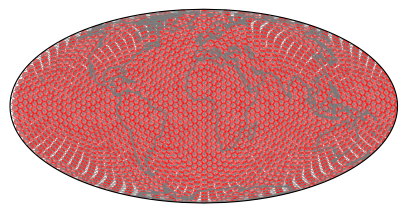

In [11]:
fig = plt.figure(figsize=(5, 6.6), facecolor="none")

ax = plt.subplot(111, projection=ccrs.Mollweide(central_longitude=0.0,  globe=None))
ax.coastlines(color="#777777")
ax.set_global()
ax.scatter(lons0, lats0, color="Red", alpha=0.5,
                 marker="o", s=20, transform=ccrs.PlateCarree())


segs = mesh.identify_segments()

for s1, s2 in segs:
    ax.plot( [lons0[s1], lons0[s2]],
              [lats0[s1], lats0[s2]], 
              linewidth=0.5, color="gray", transform=ccrs.Geodetic())
 
# plt.savefig("earth_mesh.pdf", dpi=300, facecolor='none', edgecolor='none', transparent=True, bbox_inches='tight')

In [12]:
distances, vertices = mesh.nearest_vertices(lons, lats, k=1)
nodes, ncounts = np.unique(vertices, return_counts=True)

hit_countn = np.zeros_like(mesh.lons)
hit_countn[nodes] = ncounts
eqs['mesh vertex'] = vertices


In [13]:
for year in years_uniq:
   _, eqs_per_year[year]['mesh vertex'] = mesh.nearest_vertices(eqs_per_year[year]['lons'] , eqs_per_year[year]['lats'], k=1)
   eqs_per_year[year]['mesh vertex'] = eqs_per_year[year]['mesh vertex'].reshape(-1)

### now we have two dicts: one is eqs total and one is eqs per year 

In [14]:
eqs_per_year[2018]['mesh vertex'], eqs_per_year[2018]['mags'], eqs['mags']

(array([ 175,  175,  175,   58,  368, 1191,  487,  487,  487,  418, 1824,
         965,  388, 1475,   16, 1217, 1168, 1702, 1168, 1168, 1168, 1529,
          85, 1684,  528, 1314, 1603,  567, 1272,  941, 1355, 1314, 1600,
         962,  388,  242,  237,  241,  940, 1277,  940,  940,   82, 1885,
         549,  368,  233, 1716,  388,  746,  891, 1272,  386, 1158, 1824,
         482, 1319,  111,  725, 1761,    6]),
 array([5.9 , 5.8 , 7.2 , 5.6 , 5.5 , 5.6 , 5.6 , 5.7 , 6.  , 5.8 , 5.6 ,
        5.8 , 5.9 , 5.6 , 5.6 , 5.6 , 5.7 , 5.6 , 6.4 , 5.5 , 6.1 , 6.  ,
        5.5 , 6.  , 5.5 , 5.7 , 5.6 , 6.1 , 5.5 , 5.5 , 6.6 , 5.7 , 6.3 ,
        5.75, 5.7 , 6.2 , 5.8 , 6.3 , 5.5 , 5.6 , 5.6 , 7.9 , 6.  , 6.3 ,
        6.3 , 5.6 , 5.7 , 5.8 , 5.9 , 5.8 , 5.5 , 7.1 , 5.8 , 6.  , 5.5 ,
        5.5 , 7.5 , 5.8 , 5.5 , 5.5 , 5.9 ]),
 array([5.9, 5.8, 7.2, ..., 5.9, 6.4, 5.8]))

In [15]:
year_of_interest = 2008
# expand the signal of interest to the dimension of mesh vertices
signal = np.zeros_like(mesh.lons)
signal[eqs_per_year[year_of_interest]['mesh vertex']] = eqs_per_year[year_of_interest]['mags']

In [16]:
cmap = plt.cm.Reds

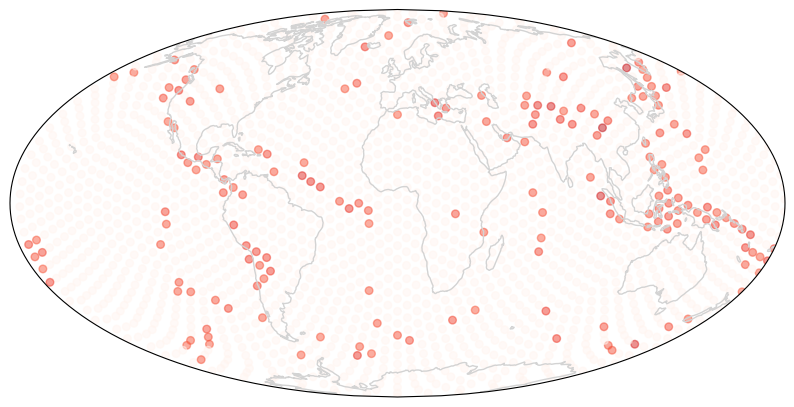

In [17]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

ax.scatter(lons0, lats0, 
            marker="o", s=30.0, transform=ccrs.PlateCarree(), c=signal, cmap=cmap, vmin=0.333, vmax=10.0, alpha=0.5)



### create a mesh graph 

In [18]:
import networkx as nx

In [19]:
# 1 nn finds the nodes themselves when using mesh.lons, mesh.lats
mesh_vertices = mesh.nearest_vertices(mesh.lons, mesh.lats, k=1)[1] .reshape(-1) # use the mesh vertices to build a graph 

/Users/mmstudio/opt/anaconda3/lib/python3.9/site-packages/stripy/spherical.py:1600: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos((extxyz * vertxyz).sum(axis=1))


### notes
- if use mesh.nearest_vertices(lons,lats), we obtain the cloest mesh points for each coordinate, which makes sense since we want to allocate the eqs to the nearest mesh points.
- if the input is (mesh.lons,mesh.lats), we obtain the point itself included since the inputs are already mesh points.


In [20]:
# 1 nn finds the nodes themselves
mesh_vertices = mesh.nearest_vertices(lons, lats, k=1)[1].reshape(-1)
vertices, counts = np.unique(mesh_vertices, return_counts =True)
print('unique vertices total number', vertices.shape)

unique vertices total number (576,)


upto here, we did things reasonably because we want to build a graph using the collected eqs. 

In [21]:
k = 10
edges = []
# for node in mesh_vertices: # if building the graph from the mesh vertices
for node in vertices: 
    distances, nbrs = mesh.nearest_vertices(mesh.lons[node], mesh.lats[node], k=k)
    # print(node, distances, nbrs)
    nbr = nbrs[0][1:]
    distance = distances[0][1:]
    # print(node, distances, nbrs)
    for d, nbr in zip(distance, nbr):
        if nbr not in vertices:
            continue
        edges.append((node, nbr, {"dist": d}))

In [22]:
weights = [e[2]["dist"] for e in edges]
mean_weight =  np.mean(weights)

before we used unweighted with 10NN graph 

In [23]:
G = nx.Graph()
G.add_nodes_from(vertices)
# G.add_weighted_edges_from(edges)
# G.add_weighted_edges_from(list((edge[0], edge[1], edge[2]['dist']) for edge in edges))
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=1)
    
L = nx.laplacian_matrix(G, weight="weight").toarray()
L = nx.normalized_laplacian_matrix(G, weight="weight").toarray()
A = nx.adjacency_matrix(G, weight="weight").toarray()
D = np.diag(np.sum(A, axis=1))

degrees = np.diag(D)
print(G.number_of_nodes(), G.number_of_edges())

576 1529


In [509]:
# G = nx.Graph()
# G.add_nodes_from(vertices)
# for edge in edges:
#     G.add_edge(edge[0], edge[1], weight=1/((edge[2]['dist']/mean_weight)**2))
    
# L = nx.laplacian_matrix(G, weight="weight").toarray()
# L = nx.normalized_laplacian_matrix(G, weight="weight").toarray()
# A = nx.adjacency_matrix(G, weight="weight").toarray()
# D = np.diag(np.sum(A, axis=1))

# degrees = np.diag(D)
# print(G.number_of_nodes(), G.number_of_edges())

we prefer to build the graph only using the unique vertices which appeared in the eqs. 

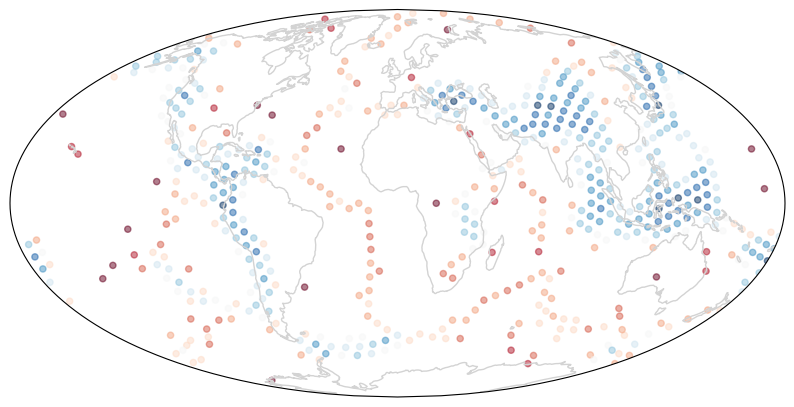

In [24]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

ax.scatter(lons0[G.nodes], lats0[G.nodes], 
            marker="o", s=20.0, transform=ccrs.PlateCarree(), c=degrees, cmap=plt.cm.RdBu, alpha=0.5)

# append the colorbar 
# plt.colorbar(ax.scatter([], [], c=[], cmap=plt.cm.RdBu), ax=ax, label='Degree of the node')


### use the signal per year as an individual signal on the graph

In [25]:
# use the nodes as keys and store the data in a dictionary
gs = {}
for year in years_uniq: 
    signal = {}
    for node in G.nodes:
        # find the mags at that node based on the stored vertices 
        iii = np.where(eqs_per_year[year]['mesh vertex']==node) # first find the index of the node in the mesh vertices
        if len(iii[0]) == 0:
            signal[node] = 0 # 0.333 # before we have 0
        else: 
            signal[node] = np.median(eqs_per_year[year]['mags'][iii])# np.mean(eqs_per_year[year]['mags'][iii])

    gs[year] = signal
    
# build the graph signal matrix
gs_matrix = []
for year in years_uniq:
    gs_matrix.append(list(gs[year].values()))

gs_matrix = np.array(gs_matrix)[:,:]

print(gs_matrix.shape)

(29, 576)


In [26]:
ori = gs_matrix.copy()
mean = np.mean(gs_matrix, axis=0)
std = np.std(gs_matrix, axis=0)
gs_min = np.min(gs_matrix)
# gs_min = 0.333
gs_max = np.max(gs_matrix)
# count the number of nodes with signals larger than 0.333
count = np.sum(gs_matrix > 0.333, axis=1)
count

gs_matrix = (gs_matrix - mean) #/ std
gs_matrix = 1 * (gs_matrix - gs_min) / (gs_max - gs_min) -0 ## performs better: normalization is more useful when the data is not normally distributed
# replace the nan values by the corresponding values in ori 
nan_indices = np.where(np.isnan(gs_matrix))
gs_matrix[nan_indices] = ori[nan_indices]

### use the total collections of eqs as a single signal on the graph --- NOT GOOD

In [513]:
# # use the nodes as keys and store the data in a dictionary
# gs = []
# for node in G.nodes:
#     # find the mags at that node based on the stored vertices 
#     iii = np.where(eqs['mesh vertex']==node)
#     if len(iii[0]) == 0:
#         signal[node] = 0.333
#     else:
#         signal[node] = np.mean(eqs['mags'][iii[0]])

# gs.append(list(signal.values()))
# gs = np.array(gs).T.reshape(-1)
# gs.shape
# mean = np.mean(gs, axis=0)
# std = np.std(gs, axis=0)
# gs_min = np.min(gs)
# gs_max = np.max(gs)
# print(gs_min, gs_max, mean, std)
# # gs = (gs - mean) / std
# gs = (gs - gs_min) / (gs_max - gs_min)

In [27]:
signal_of_interest = gs_matrix[19,:]
# signal_of_interest = gs

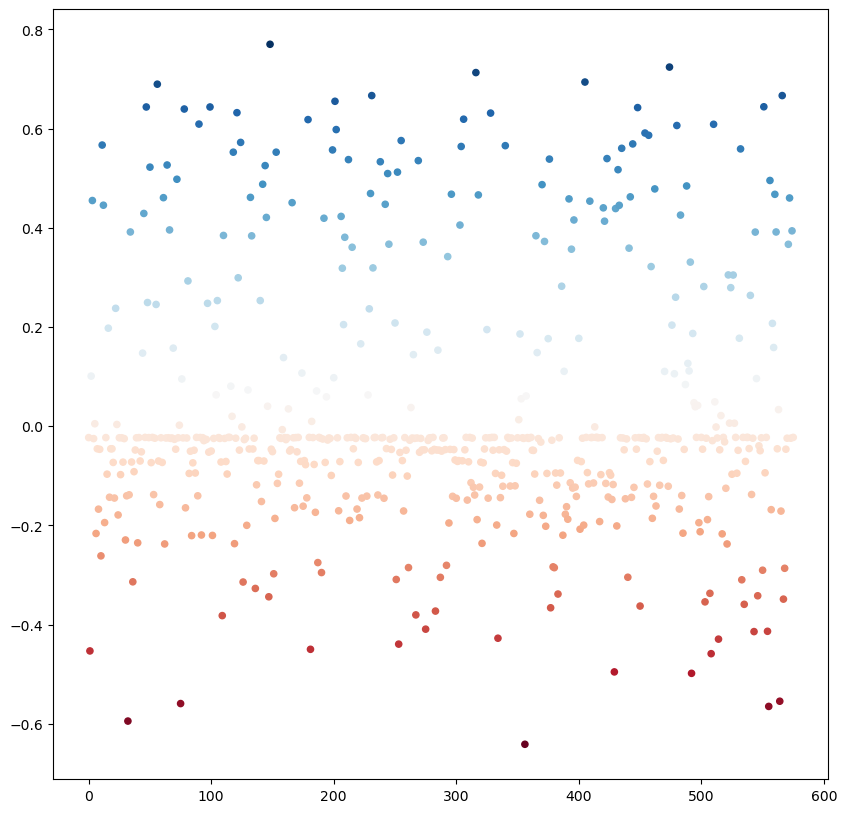

In [28]:
cmap = plt.cm.RdBu
# scatter the signal in a xy plot
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111)
ax.scatter(np.arange(0, len(signal_of_interest)), signal_of_interest, c=signal_of_interest, cmap=cmap, s=20.0)

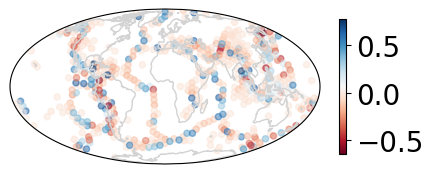

In [29]:
fig = plt.figure(figsize=(5, 2.5), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

ax.scatter(lons0[G.nodes], lats0[G.nodes], 
            marker="o", s=20.0, transform=ccrs.PlateCarree(), c=signal_of_interest, cmap=cmap, alpha=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(signal_of_interest), vmax=max(signal_of_interest)))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.05, shrink=0.7)
# set colorbar tick size
cbar.ax.tick_params(labelsize=20)
# shrink the colorbar
# cbar.set_label('Magnitude')
# plt.show()
# plt.savefig("earthquake_data_sample.pdf", dpi=300, facecolor='none', edgecolor='none', transparent=True, bbox_inches='tight')

In [1]:
# check if L is symmetric
is_symmetric = np.allclose(L, L.T, atol=1e-8)

NameError: name 'np' is not defined

In [31]:
eigvals, eigvecs = np.linalg.eigh(L)

In [32]:
eigvals[-50:]

array([1.51088543, 1.51567299, 1.51741716, 1.51829504, 1.51905133,
       1.52289565, 1.52550546, 1.53290212, 1.53515815, 1.54135736,
       1.55025598, 1.55207402, 1.55519178, 1.56255425, 1.56509611,
       1.56673594, 1.57259615, 1.57477624, 1.57934874, 1.57956247,
       1.58193917, 1.59917245, 1.60862478, 1.61650554, 1.61652811,
       1.62270937, 1.62984921, 1.63501777, 1.63655492, 1.64444826,
       1.66068197, 1.6612203 , 1.66623316, 1.66894304, 1.68147932,
       1.68406453, 1.6847784 , 1.71558343, 1.74222357, 1.75639355,
       1.77913244, 1.78162436, 1.78776167, 1.81107397, 1.81428728,
       1.85452776, 1.86221838, 2.        , 2.        , 2.        ])

Save the data

In [ ]:
# # # export the graph and data to a file
# import pickle
# with open("eqs.pkl", "wb") as f:
#     pickle.dump(G, f)
#     pickle.dump(L, f)
#     pickle.dump(eigvals, f)
#     pickle.dump(eigvecs, f)
#     # pickle.dump(gs, f) # save the total signal
#     pickle.dump(gs_matrix, f) # save the matrix signal per year